In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy.fft as fft

In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(device)

cpu


In [3]:
num_frames = 100

num_alphas = 10
alphlowlim = 0.0
alphhighlim = 0.9
num_ds = 50
dlowlim = 0.0
dhighlim = 4.9

In [4]:
alpha_vals = np.linspace(alphlowlim, alphhighlim, num_alphas)
print(alpha_vals)
alpha_vals[0] = 1e-10 # set alpha=0 to a small value

d_vals = np.linspace(dlowlim, dhighlim, num_ds)
print(d_vals)
d_vals[0] = 1e-10 # set d=0 to a small value


r_vals = np.linspace(0.0, 10.0, 501)
r_vals = r_vals[:-1]
r_vals[0] = 1e-10 # set r=0 to a small value

k_vals = fft.fftfreq(r_vals.shape[0], d=r_vals[1]-r_vals[0])

# convert to tensor
r_vals = torch.from_numpy(r_vals).float().to(device)


# print the shape of the data
print(f"shape of alpha_vals : {alpha_vals.shape}")
print(f"shape of d_vals : {d_vals.shape}")

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9]
shape of alpha_vals : (10,)
shape of d_vals : (50,)


In [5]:
# initial guess for P_alpha_d
P_alpha_d = np.zeros((num_frames, num_alphas, num_ds))
# for i in range(num_frames):
#     P_alpha_d[i, 0, 0] = 1.0


alpha0 = 0.5
d0 = 2.0
for i in range(num_alphas):
    for j in range(num_ds):
        P_alpha_d[:, i, j] = np.exp(-((alpha_vals[i] - alpha0)**2 + (d_vals[j] - d0)**2) / 0.1)

# # normalize P_alpha_d
P_alpha_d = P_alpha_d / np.trapz(np.trapz(P_alpha_d, x=d_vals, axis=2), x=alpha_vals, axis=1)[:, None, None]
# P_alpha_d = P_alpha_d / np.sum(P_alpha_d, axis=(1, 2))[:, None, None]


# convert to tensor
alpha_vals = torch.from_numpy(alpha_vals).float().to(device)
# convert to tensor
d_vals = torch.from_numpy(d_vals).float().to(device)
# convert to tensor
k_vals = torch.from_numpy(k_vals).float().to(device)

# convert P_alpha_d to torch tensor
P_alpha_d = torch.tensor(P_alpha_d, dtype=torch.float32, device=device, requires_grad=True)
# restrict P_alpha_d to be positive while training
# P_alpha_d = torch.clamp(P_alpha_d, min=0.0)
# print(P_alpha_d)

In [6]:
def contour_plt(P_alpha_d, i=0):
    """
    Visualise P_alpha_d as a countour plot using contourf
    """
    # plot
    # rescale the y axis to be in the range of 0 to 2
    # rescale the x axis to be in the range of 0 to 1000
    # check if P_alpha_d is a torch tensor
    if isinstance(P_alpha_d, torch.Tensor):
        P_alpha_d_copy = P_alpha_d.detach().cpu().numpy()
    else:
        P_alpha_d_copy = P_alpha_d.copy()
    plt.figure(figsize=(4, 4))
    x = np.linspace(dlowlim, dhighlim, num_ds)
    y = np.linspace(alphlowlim, alphhighlim, num_alphas)
    plt.contourf(x, y, P_alpha_d_copy[i], 20, cmap='RdGy')
    plt.xlabel('d')
    plt.ylabel('alpha')
    plt.colorbar()
    plt.show()

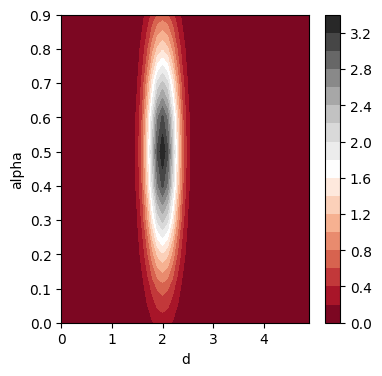

In [7]:
# # visualize P_alpha_d inital in subplots
# for i in range(num_frames):
#     contour_plt(P_alpha_d, i)
contour_plt(P_alpha_d, 50)

In [8]:
# load u_pred
u = np.loadtxt("u.txt")
print(f"shape of u : {u.shape}")
# print(u_pred)
# convert to torch tensor
u = torch.tensor(u, dtype=torch.float32, device=device)
print(f"shape of u : {u.shape}")

shape of u : (100, 500)
shape of u : torch.Size([100, 500])


In [9]:
# load Z
Z = np.load("Z.npy")
print(f"shape of Z : {Z.shape}")
# convert Z to torch tensor
Z = torch.from_numpy(Z).float().to(device)
# print shape of Z
print(f"shape of Z : {Z.shape}")
# print(Z)
# normalize Z to have integral of Z over r equal to 1
# Z = Z / np.sum(Z * (r_vals[1]-r_vals[0]))
# print(Z)

shape of Z : (10, 50, 100, 500)
shape of Z : torch.Size([10, 50, 100, 500])


In [10]:
def give_u_pred(P_alpha_d, Z, alpha_vals, d_vals):
    """
    Given P_alpha_d, Z, alpha_vals, d_vals, return u_pred
    """
    # initialize u_pred
    u_pred = torch.zeros((num_frames, len(r_vals)))
    # move u_pred to device
    u_pred = u_pred.to(device)

    for i in range(u_pred.shape[0]):
        for j in range(u_pred.shape[1]):
            integrand = torch.trapz(P_alpha_d[i] * Z[:, :, i, j], d_vals)
            u_pred[i, j] = torch.trapz(integrand, alpha_vals)

    # normalize u_pred
    # u_pred = u_pred / (u_pred.sum(dim=1, keepdim=True) + 1e-9)
    # u_pred = u_pred / (torch.trapz(u_pred, k_vals, dim=1, keepdim=True) + 1e-9)
    
    # norm = (torch.trapz(u_pred, k_vals, dim=1))

    # u_pred = u_pred / norm[:, None]


    return u_pred    

In [11]:
# manual loss function
def loss_function(P_alpha_d, u, Z, alpha_vals, d_vals):
    # clamp P_alpha_d to be positive
    # P_alpha_d.data = P_alpha_d.data.clamp(min=0.0)
    # normalize P_alpha_d
    norm = (torch.trapz(torch.trapz(P_alpha_d, d_vals, dim=2), alpha_vals, dim=1))
    P_alpha_d = P_alpha_d / norm[:, None, None]
    # P_alpha_d = P_alpha_d / (torch.trapz(torch.trapz(P_alpha_d, d_vals, dim=2), alpha_vals, dim=1, keepdim=True) + 1e-6)
    # P_alpha_d = P_alpha_d / (P_alpha_d.sum(dim=(1,2), keepdim=True))
    # P_alpha_d = P_alpha_d / (P_alpha_d.sum(dim=(1,2), keepdim=True) + 1e-6)
    # calculate u_pred using double integral
    u_pred = give_u_pred(P_alpha_d, Z, alpha_vals, d_vals)
    # calculate loss
    loss = torch.sum((u_pred - u)**2)
    # loss /= u.shape[0] * u.shape[1]
    # loss = torch.sum(abs(u_pred - u))

    return loss

In [12]:
# write a function to train the model
def train(P_alpha_d, u, Z, alpha_vals, d_vals, num_epochs=100, lr=1e-1):
    # define the optimizer
    optimizer = torch.optim.Adam([P_alpha_d], lr=lr)
    # define the loss function
    loss_func = loss_function
    # define the loss history
    loss_history = []
    # train the model
    for epoch in range(num_epochs):
        # calculate loss
        loss = loss_func(P_alpha_d, u, Z, alpha_vals, d_vals)
        # zero the gradients
        optimizer.zero_grad()
        # backpropagate
        loss.backward()
        # update parameters
        optimizer.step()
        # append loss to loss history
        loss_history.append(loss.item())
        P_alpha_d.data = P_alpha_d.data.clamp(min=0.0)

        # plot P_alpha_d
        if (epoch+1) % 5 == 0:
            contour_plt(P_alpha_d, 50)
        # print loss
        if (epoch+1) % 1 == 0:
            print(f"epoch {epoch+1} / {num_epochs} : loss = {loss.item()}")
    # plot loss history
    plt.figure()
    plt.plot(loss_history)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    return P_alpha_d

epoch 1 / 500 : loss = 107352.0078125
epoch 2 / 500 : loss = 107281.296875
epoch 3 / 500 : loss = 107227.046875
epoch 4 / 500 : loss = 107183.390625


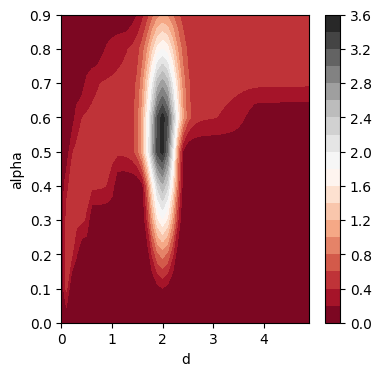

epoch 5 / 500 : loss = 107147.875
epoch 6 / 500 : loss = 107117.4453125
epoch 7 / 500 : loss = 107091.2109375
epoch 8 / 500 : loss = 107069.109375
epoch 9 / 500 : loss = 107049.6796875


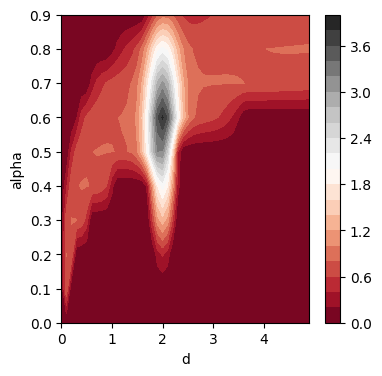

epoch 10 / 500 : loss = 107031.6796875
epoch 11 / 500 : loss = 107015.5546875
epoch 12 / 500 : loss = 107000.4375
epoch 13 / 500 : loss = 106985.921875
epoch 14 / 500 : loss = 106972.953125


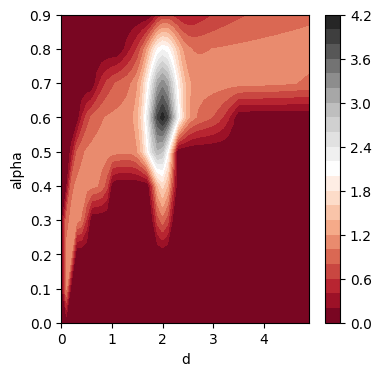

epoch 15 / 500 : loss = 106960.96875
epoch 16 / 500 : loss = 106949.734375
epoch 17 / 500 : loss = 106939.03125
epoch 18 / 500 : loss = 106928.5703125
epoch 19 / 500 : loss = 106918.5546875


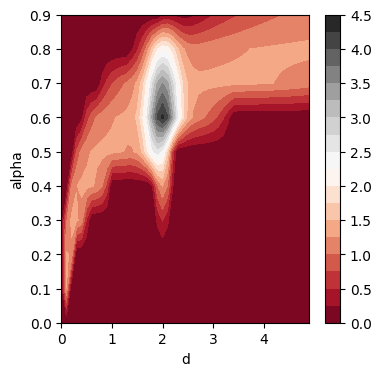

epoch 20 / 500 : loss = 106908.96875
epoch 21 / 500 : loss = 106899.8828125
epoch 22 / 500 : loss = 106892.3984375
epoch 23 / 500 : loss = 106885.15625
epoch 24 / 500 : loss = 106878.8515625


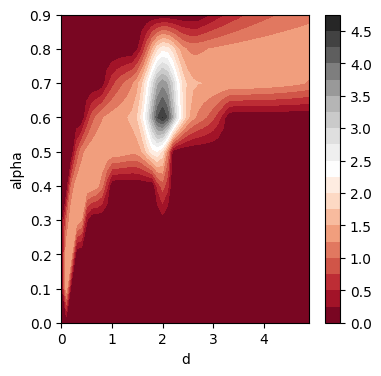

epoch 25 / 500 : loss = 106873.078125
epoch 26 / 500 : loss = 106867.6484375
epoch 27 / 500 : loss = 106862.671875
epoch 28 / 500 : loss = 106858.1796875
epoch 29 / 500 : loss = 106854.390625


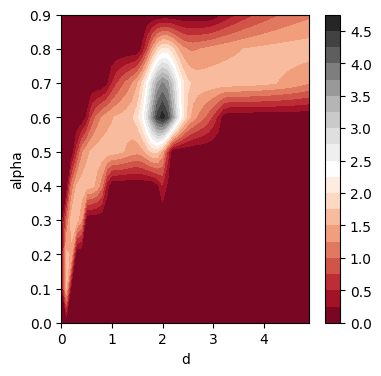

epoch 30 / 500 : loss = 106850.734375
epoch 31 / 500 : loss = 106847.375
epoch 32 / 500 : loss = 106844.546875
epoch 33 / 500 : loss = 106841.8515625
epoch 34 / 500 : loss = 106839.3515625


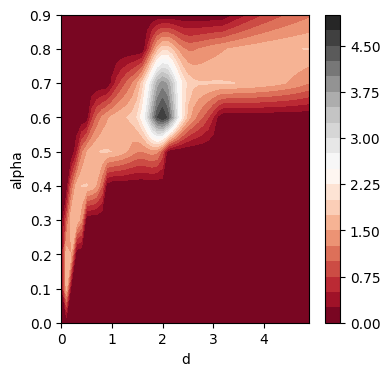

epoch 35 / 500 : loss = 106837.1328125
epoch 36 / 500 : loss = 106834.9609375
epoch 37 / 500 : loss = 106832.796875
epoch 38 / 500 : loss = 106830.6015625
epoch 39 / 500 : loss = 106828.390625


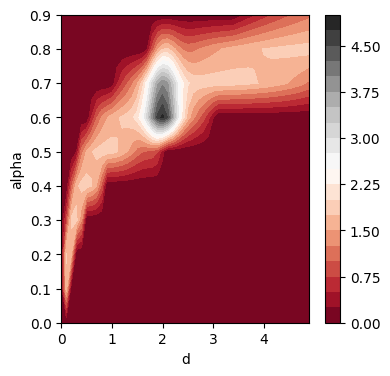

epoch 40 / 500 : loss = 106826.1640625
epoch 41 / 500 : loss = 106823.953125
epoch 42 / 500 : loss = 106821.71875
epoch 43 / 500 : loss = 106819.4765625
epoch 44 / 500 : loss = 106817.1953125


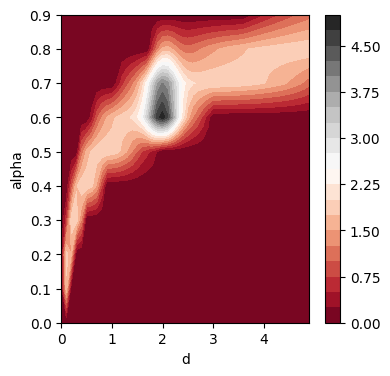

epoch 45 / 500 : loss = 106814.9375
epoch 46 / 500 : loss = 106812.6015625
epoch 47 / 500 : loss = 106810.2421875
epoch 48 / 500 : loss = 106807.8671875
epoch 49 / 500 : loss = 106805.421875


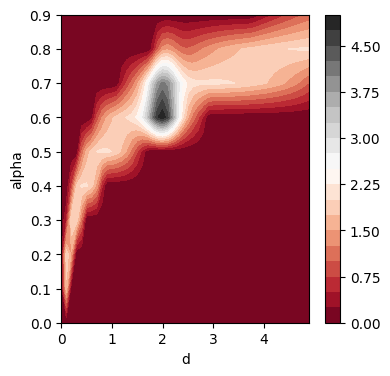

epoch 50 / 500 : loss = 106802.890625
epoch 51 / 500 : loss = 106800.3828125
epoch 52 / 500 : loss = 106797.7265625
epoch 53 / 500 : loss = 106794.9609375
epoch 54 / 500 : loss = 106792.140625


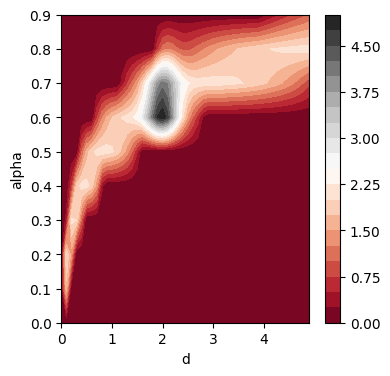

epoch 55 / 500 : loss = 106789.2109375
epoch 56 / 500 : loss = 106786.1875
epoch 57 / 500 : loss = 106783.0078125
epoch 58 / 500 : loss = 106779.6484375
epoch 59 / 500 : loss = 106776.2421875


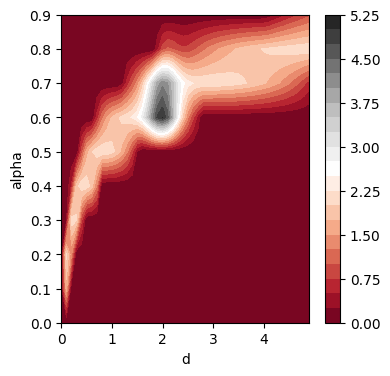

epoch 60 / 500 : loss = 106772.6171875
epoch 61 / 500 : loss = 106768.75
epoch 62 / 500 : loss = 106764.6953125
epoch 63 / 500 : loss = 106760.8125
epoch 64 / 500 : loss = 106757.03125


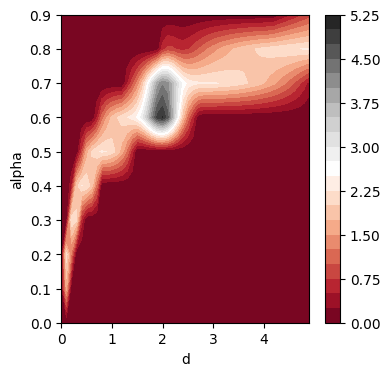

epoch 65 / 500 : loss = 106753.3515625
epoch 66 / 500 : loss = 106749.75
epoch 67 / 500 : loss = 106746.1640625
epoch 68 / 500 : loss = 106743.0390625
epoch 69 / 500 : loss = 106739.953125


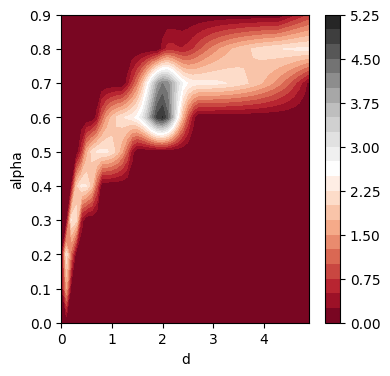

epoch 70 / 500 : loss = 106737.46875
epoch 71 / 500 : loss = 106735.125
epoch 72 / 500 : loss = 106733.0234375
epoch 73 / 500 : loss = 106731.1640625
epoch 74 / 500 : loss = 106729.5625


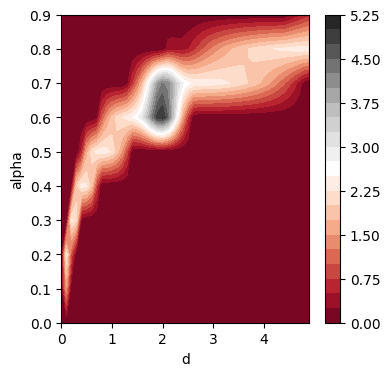

epoch 75 / 500 : loss = 106728.203125
epoch 76 / 500 : loss = 106727.203125
epoch 77 / 500 : loss = 106726.4765625
epoch 78 / 500 : loss = 106725.8671875
epoch 79 / 500 : loss = 106725.265625


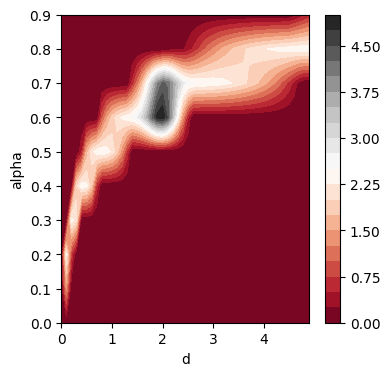

epoch 80 / 500 : loss = 106724.6484375
epoch 81 / 500 : loss = 106724.015625
epoch 82 / 500 : loss = 106723.375
epoch 83 / 500 : loss = 106722.8125
epoch 84 / 500 : loss = 106722.234375


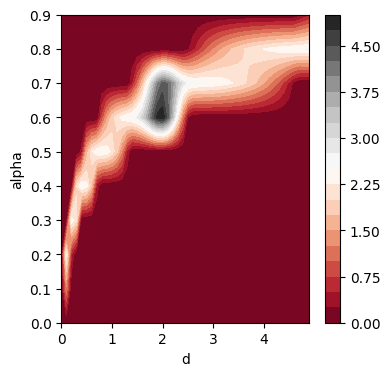

epoch 85 / 500 : loss = 106721.640625
epoch 86 / 500 : loss = 106721.0390625
epoch 87 / 500 : loss = 106720.46875
epoch 88 / 500 : loss = 106719.9140625
epoch 89 / 500 : loss = 106719.3671875


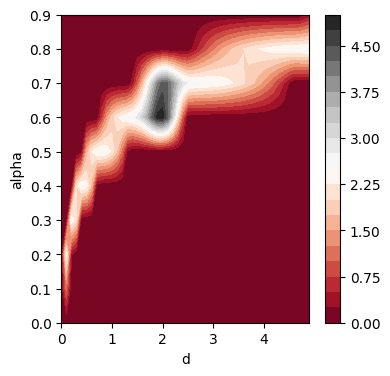

epoch 90 / 500 : loss = 106718.8046875
epoch 91 / 500 : loss = 106718.25
epoch 92 / 500 : loss = 106717.71875
epoch 93 / 500 : loss = 106717.234375
epoch 94 / 500 : loss = 106716.703125


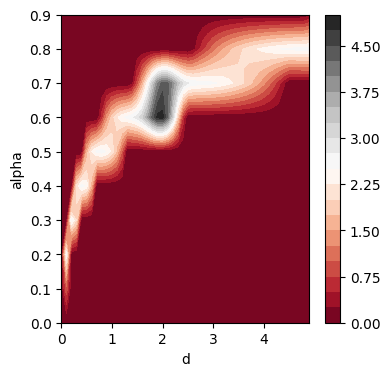

epoch 95 / 500 : loss = 106716.1796875
epoch 96 / 500 : loss = 106715.6953125
epoch 97 / 500 : loss = 106715.2109375
epoch 98 / 500 : loss = 106714.75
epoch 99 / 500 : loss = 106714.2578125


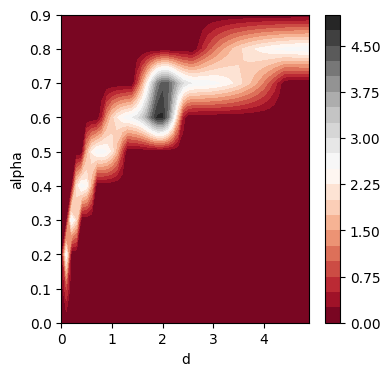

epoch 100 / 500 : loss = 106713.78125
epoch 101 / 500 : loss = 106713.34375
epoch 102 / 500 : loss = 106712.8984375
epoch 103 / 500 : loss = 106712.4375
epoch 104 / 500 : loss = 106711.9921875


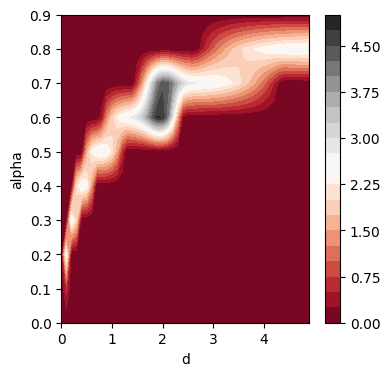

epoch 105 / 500 : loss = 106711.5703125
epoch 106 / 500 : loss = 106711.15625
epoch 107 / 500 : loss = 106710.7421875
epoch 108 / 500 : loss = 106710.3046875
epoch 109 / 500 : loss = 106709.9140625


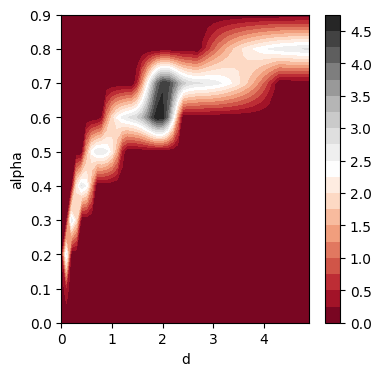

epoch 110 / 500 : loss = 106709.5390625
epoch 111 / 500 : loss = 106709.15625
epoch 112 / 500 : loss = 106708.765625
epoch 113 / 500 : loss = 106708.359375
epoch 114 / 500 : loss = 106708.0078125


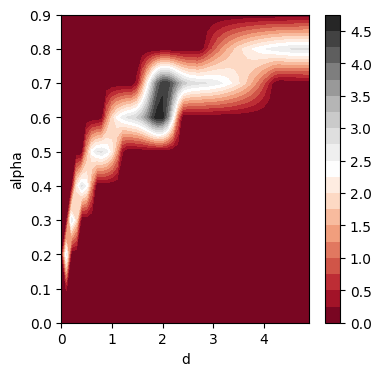

epoch 115 / 500 : loss = 106707.640625
epoch 116 / 500 : loss = 106707.2734375
epoch 117 / 500 : loss = 106706.90625
epoch 118 / 500 : loss = 106706.5625
epoch 119 / 500 : loss = 106706.2265625


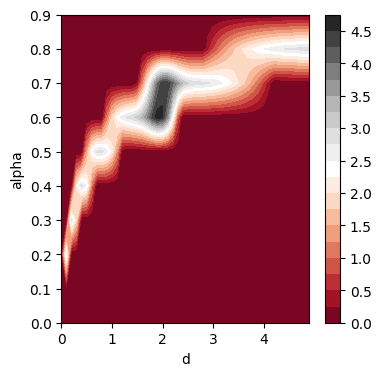

epoch 120 / 500 : loss = 106705.8984375
epoch 121 / 500 : loss = 106705.5546875
epoch 122 / 500 : loss = 106705.21875
epoch 123 / 500 : loss = 106704.8828125
epoch 124 / 500 : loss = 106704.5703125


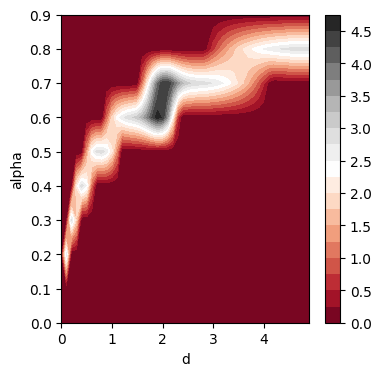

epoch 125 / 500 : loss = 106704.2578125
epoch 126 / 500 : loss = 106703.9453125
epoch 127 / 500 : loss = 106703.625
epoch 128 / 500 : loss = 106703.3046875
epoch 129 / 500 : loss = 106702.9921875


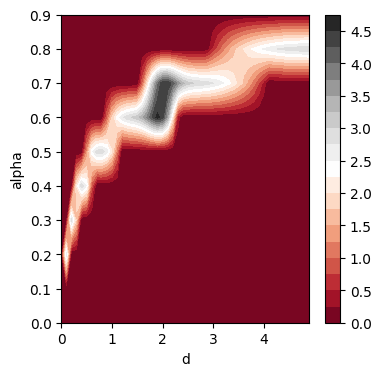

epoch 130 / 500 : loss = 106702.703125
epoch 131 / 500 : loss = 106702.390625
epoch 132 / 500 : loss = 106702.09375
epoch 133 / 500 : loss = 106701.7890625
epoch 134 / 500 : loss = 106701.484375


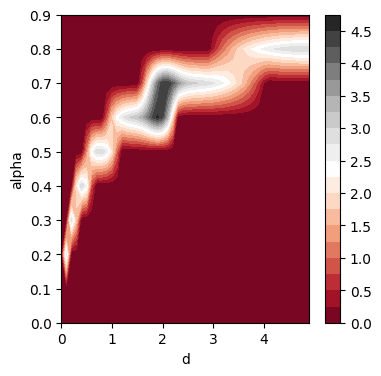

epoch 135 / 500 : loss = 106701.171875
epoch 136 / 500 : loss = 106700.875
epoch 137 / 500 : loss = 106700.59375
epoch 138 / 500 : loss = 106700.328125
epoch 139 / 500 : loss = 106700.0234375


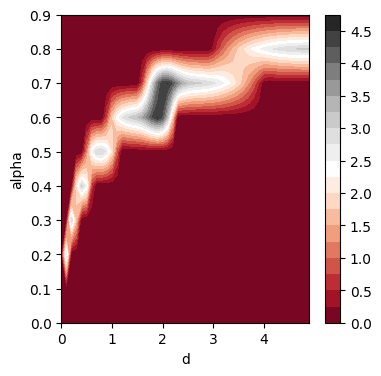

epoch 140 / 500 : loss = 106699.7578125
epoch 141 / 500 : loss = 106699.4609375
epoch 142 / 500 : loss = 106699.15625
epoch 143 / 500 : loss = 106698.8671875
epoch 144 / 500 : loss = 106698.5625


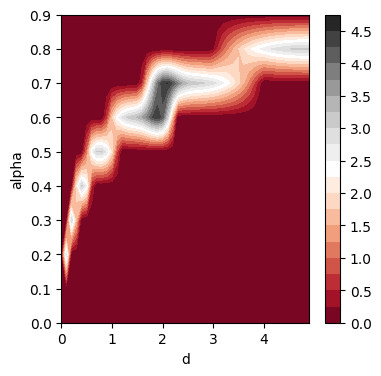

epoch 145 / 500 : loss = 106698.296875
epoch 146 / 500 : loss = 106698.0390625
epoch 147 / 500 : loss = 106697.7734375
epoch 148 / 500 : loss = 106697.484375
epoch 149 / 500 : loss = 106697.21875


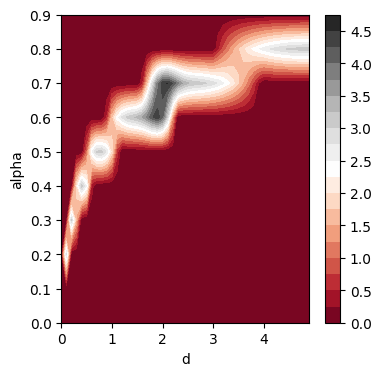

epoch 150 / 500 : loss = 106696.921875
epoch 151 / 500 : loss = 106696.625
epoch 152 / 500 : loss = 106696.34375
epoch 153 / 500 : loss = 106696.0859375
epoch 154 / 500 : loss = 106695.8203125


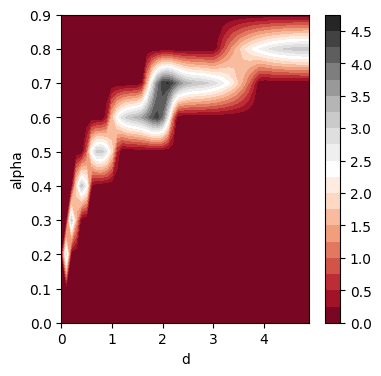

epoch 155 / 500 : loss = 106695.5859375
epoch 156 / 500 : loss = 106695.2890625
epoch 157 / 500 : loss = 106695.0390625
epoch 158 / 500 : loss = 106694.7578125
epoch 159 / 500 : loss = 106694.46875


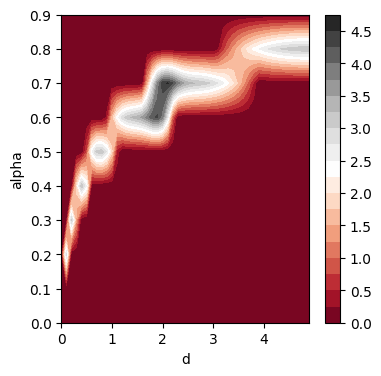

epoch 160 / 500 : loss = 106694.21875
epoch 161 / 500 : loss = 106693.984375
epoch 162 / 500 : loss = 106693.734375
epoch 163 / 500 : loss = 106693.484375
epoch 164 / 500 : loss = 106693.2109375


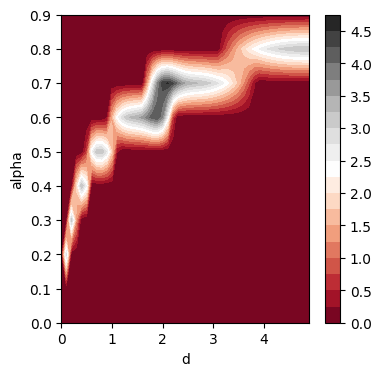

epoch 165 / 500 : loss = 106692.984375
epoch 166 / 500 : loss = 106692.7578125
epoch 167 / 500 : loss = 106692.53125
epoch 168 / 500 : loss = 106692.296875
epoch 169 / 500 : loss = 106692.0625


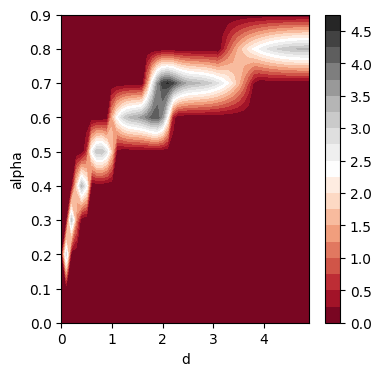

epoch 170 / 500 : loss = 106691.8671875
epoch 171 / 500 : loss = 106691.65625
epoch 172 / 500 : loss = 106691.453125
epoch 173 / 500 : loss = 106691.2421875
epoch 174 / 500 : loss = 106691.0625


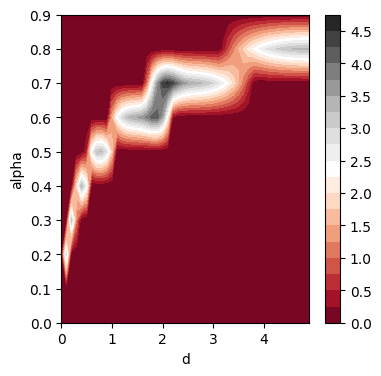

epoch 175 / 500 : loss = 106690.8828125
epoch 176 / 500 : loss = 106690.6796875
epoch 177 / 500 : loss = 106690.5
epoch 178 / 500 : loss = 106690.296875
epoch 179 / 500 : loss = 106690.140625


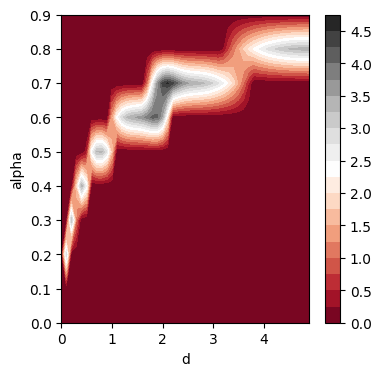

epoch 180 / 500 : loss = 106689.984375
epoch 181 / 500 : loss = 106689.8046875
epoch 182 / 500 : loss = 106689.6171875
epoch 183 / 500 : loss = 106689.46875
epoch 184 / 500 : loss = 106689.2890625


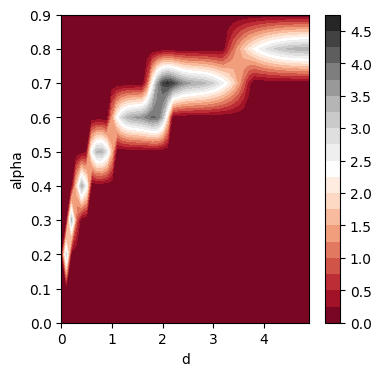

epoch 185 / 500 : loss = 106689.140625
epoch 186 / 500 : loss = 106688.9921875
epoch 187 / 500 : loss = 106688.84375
epoch 188 / 500 : loss = 106688.6953125
epoch 189 / 500 : loss = 106688.5390625


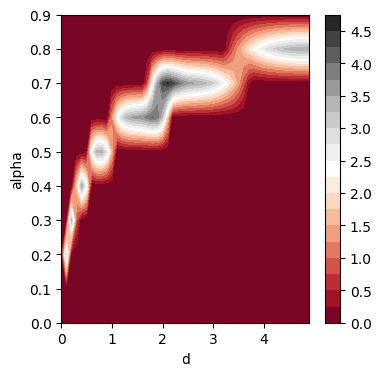

epoch 190 / 500 : loss = 106688.375
epoch 191 / 500 : loss = 106688.2109375
epoch 192 / 500 : loss = 106688.0703125
epoch 193 / 500 : loss = 106687.9296875
epoch 194 / 500 : loss = 106687.7890625


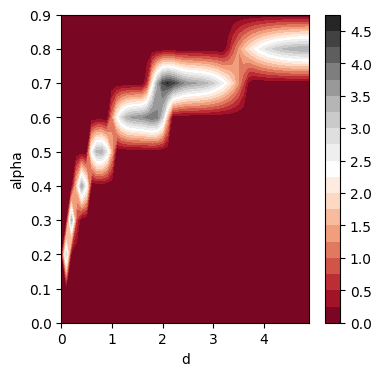

epoch 195 / 500 : loss = 106687.6484375
epoch 196 / 500 : loss = 106687.5234375
epoch 197 / 500 : loss = 106687.3671875
epoch 198 / 500 : loss = 106687.2265625
epoch 199 / 500 : loss = 106687.0859375


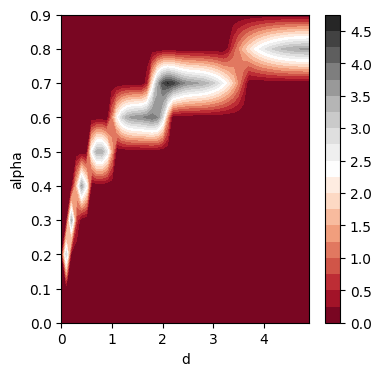

epoch 200 / 500 : loss = 106686.9140625
epoch 201 / 500 : loss = 106686.796875
epoch 202 / 500 : loss = 106686.6640625
epoch 203 / 500 : loss = 106686.5546875
epoch 204 / 500 : loss = 106686.4296875


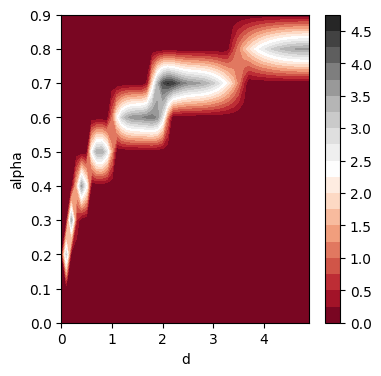

epoch 205 / 500 : loss = 106686.3046875
epoch 206 / 500 : loss = 106686.1796875
epoch 207 / 500 : loss = 106686.0390625
epoch 208 / 500 : loss = 106685.8984375
epoch 209 / 500 : loss = 106685.765625


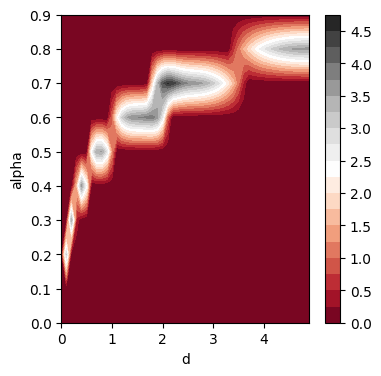

epoch 210 / 500 : loss = 106685.6640625
epoch 211 / 500 : loss = 106685.53125
epoch 212 / 500 : loss = 106685.421875
epoch 213 / 500 : loss = 106685.2890625
epoch 214 / 500 : loss = 106685.1875


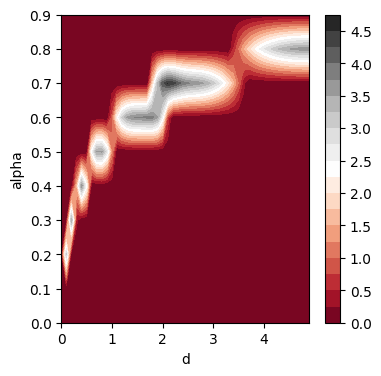

epoch 215 / 500 : loss = 106685.09375
epoch 216 / 500 : loss = 106684.9609375
epoch 217 / 500 : loss = 106684.84375
epoch 218 / 500 : loss = 106684.7265625
epoch 219 / 500 : loss = 106684.59375


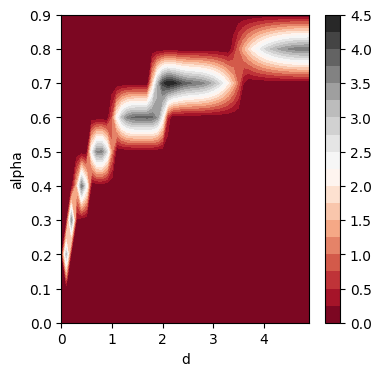

epoch 220 / 500 : loss = 106684.5078125
epoch 221 / 500 : loss = 106684.3828125
epoch 222 / 500 : loss = 106684.28125
epoch 223 / 500 : loss = 106684.203125
epoch 224 / 500 : loss = 106684.09375


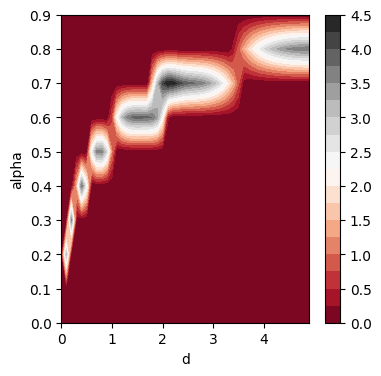

epoch 225 / 500 : loss = 106683.96875
epoch 226 / 500 : loss = 106683.859375
epoch 227 / 500 : loss = 106683.765625
epoch 228 / 500 : loss = 106683.65625
epoch 229 / 500 : loss = 106683.5390625


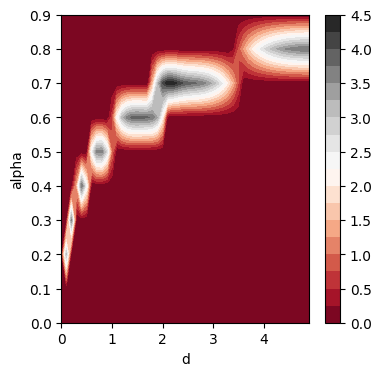

epoch 230 / 500 : loss = 106683.4296875
epoch 231 / 500 : loss = 106683.3515625
epoch 232 / 500 : loss = 106683.265625
epoch 233 / 500 : loss = 106683.1640625
epoch 234 / 500 : loss = 106683.0625


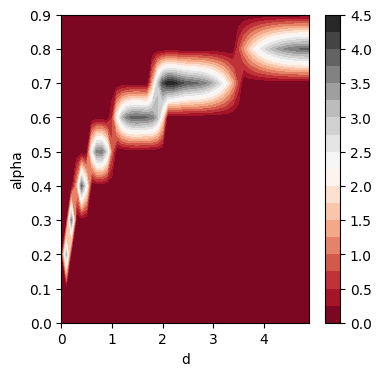

epoch 235 / 500 : loss = 106682.96875
epoch 236 / 500 : loss = 106682.875
epoch 237 / 500 : loss = 106682.7890625
epoch 238 / 500 : loss = 106682.6875
epoch 239 / 500 : loss = 106682.5859375


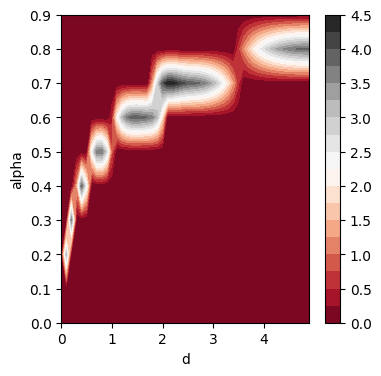

epoch 240 / 500 : loss = 106682.4765625
epoch 241 / 500 : loss = 106682.3828125
epoch 242 / 500 : loss = 106682.3046875
epoch 243 / 500 : loss = 106682.21875
epoch 244 / 500 : loss = 106682.125


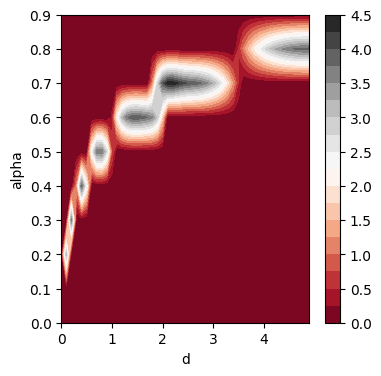

epoch 245 / 500 : loss = 106682.046875
epoch 246 / 500 : loss = 106681.9453125
epoch 247 / 500 : loss = 106681.8828125
epoch 248 / 500 : loss = 106681.8046875
epoch 249 / 500 : loss = 106681.7109375


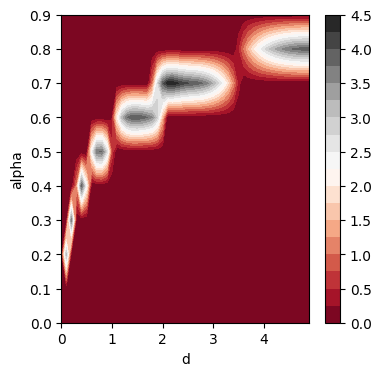

epoch 250 / 500 : loss = 106681.625
epoch 251 / 500 : loss = 106681.53125
epoch 252 / 500 : loss = 106681.453125
epoch 253 / 500 : loss = 106681.3515625
epoch 254 / 500 : loss = 106681.2734375


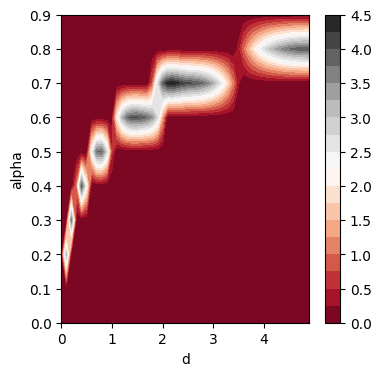

epoch 255 / 500 : loss = 106681.1796875
epoch 256 / 500 : loss = 106681.109375
epoch 257 / 500 : loss = 106681.0390625
epoch 258 / 500 : loss = 106680.96875
epoch 259 / 500 : loss = 106680.890625


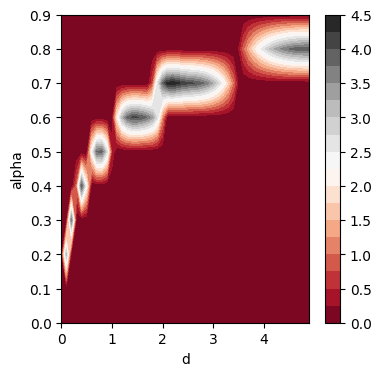

epoch 260 / 500 : loss = 106680.8125
epoch 261 / 500 : loss = 106680.734375
epoch 262 / 500 : loss = 106680.6640625
epoch 263 / 500 : loss = 106680.5859375
epoch 264 / 500 : loss = 106680.5


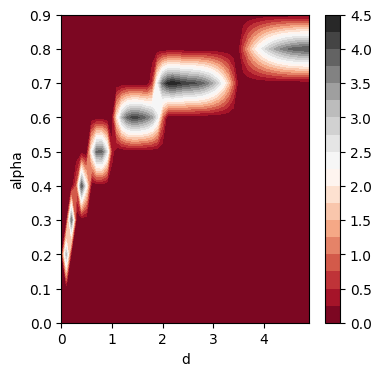

epoch 265 / 500 : loss = 106680.4375
epoch 266 / 500 : loss = 106680.3359375
epoch 267 / 500 : loss = 106680.25
epoch 268 / 500 : loss = 106680.1875
epoch 269 / 500 : loss = 106680.109375


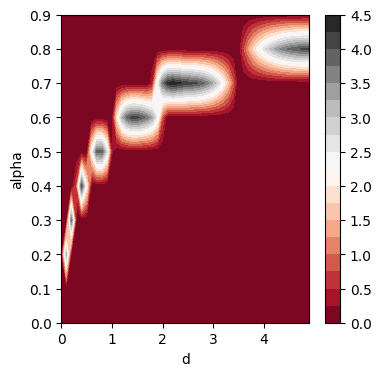

epoch 270 / 500 : loss = 106680.0546875
epoch 271 / 500 : loss = 106679.9921875
epoch 272 / 500 : loss = 106679.9140625
epoch 273 / 500 : loss = 106679.8515625
epoch 274 / 500 : loss = 106679.78125


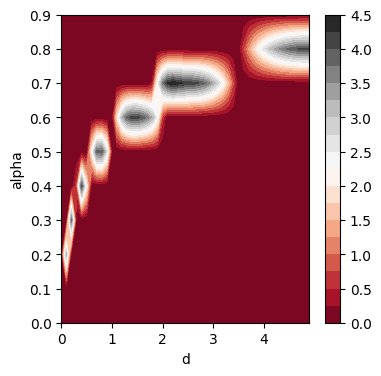

epoch 275 / 500 : loss = 106679.7109375
epoch 276 / 500 : loss = 106679.65625
epoch 277 / 500 : loss = 106679.5703125
epoch 278 / 500 : loss = 106679.5
epoch 279 / 500 : loss = 106679.4375


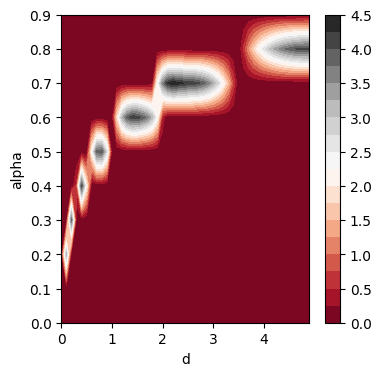

epoch 280 / 500 : loss = 106679.375
epoch 281 / 500 : loss = 106679.3046875
epoch 282 / 500 : loss = 106679.21875
epoch 283 / 500 : loss = 106679.140625
epoch 284 / 500 : loss = 106679.078125


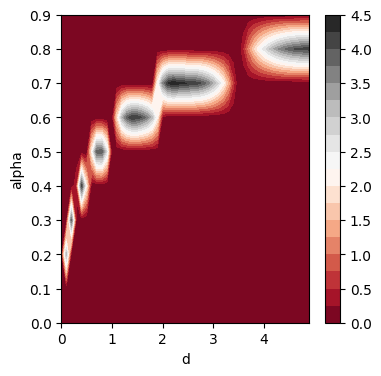

epoch 285 / 500 : loss = 106679.0390625
epoch 286 / 500 : loss = 106678.96875
epoch 287 / 500 : loss = 106678.90625
epoch 288 / 500 : loss = 106678.84375
epoch 289 / 500 : loss = 106678.8046875


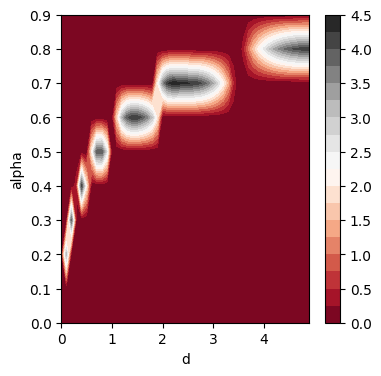

epoch 290 / 500 : loss = 106678.7265625
epoch 291 / 500 : loss = 106678.6640625
epoch 292 / 500 : loss = 106678.609375
epoch 293 / 500 : loss = 106678.5390625
epoch 294 / 500 : loss = 106678.4921875


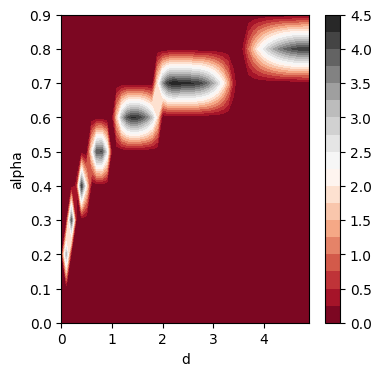

epoch 295 / 500 : loss = 106678.4375
epoch 296 / 500 : loss = 106678.375
epoch 297 / 500 : loss = 106678.3125
epoch 298 / 500 : loss = 106678.25
epoch 299 / 500 : loss = 106678.1875


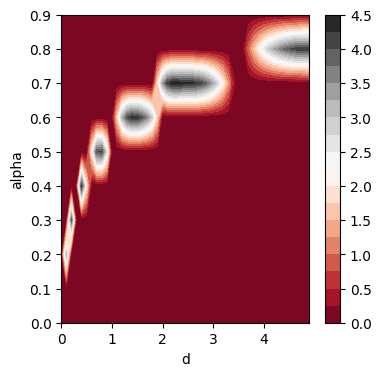

epoch 300 / 500 : loss = 106678.1171875
epoch 301 / 500 : loss = 106678.0546875
epoch 302 / 500 : loss = 106678.0
epoch 303 / 500 : loss = 106677.96875
epoch 304 / 500 : loss = 106677.90625


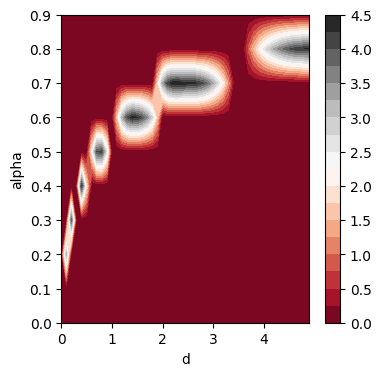

epoch 305 / 500 : loss = 106677.8671875
epoch 306 / 500 : loss = 106677.8125
epoch 307 / 500 : loss = 106677.75
epoch 308 / 500 : loss = 106677.703125
epoch 309 / 500 : loss = 106677.6484375


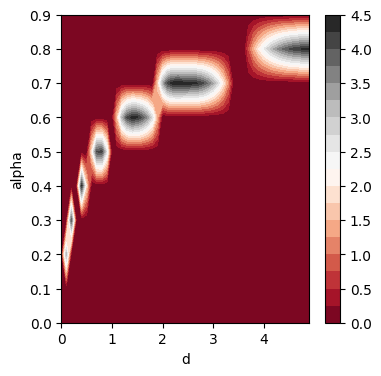

epoch 310 / 500 : loss = 106677.6015625
epoch 311 / 500 : loss = 106677.5390625
epoch 312 / 500 : loss = 106677.484375
epoch 313 / 500 : loss = 106677.4296875
epoch 314 / 500 : loss = 106677.359375


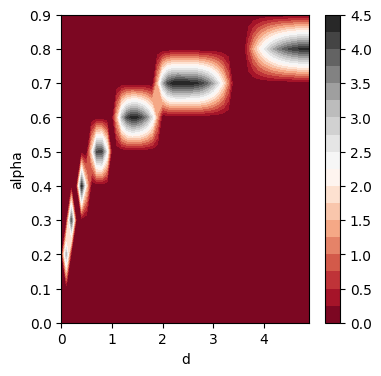

epoch 315 / 500 : loss = 106677.3125
epoch 316 / 500 : loss = 106677.265625
epoch 317 / 500 : loss = 106677.2109375
epoch 318 / 500 : loss = 106677.1484375
epoch 319 / 500 : loss = 106677.09375


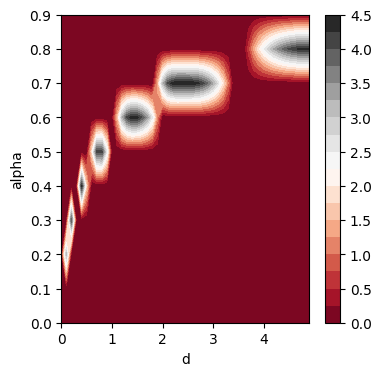

epoch 320 / 500 : loss = 106677.0703125
epoch 321 / 500 : loss = 106677.0078125
epoch 322 / 500 : loss = 106676.9609375
epoch 323 / 500 : loss = 106676.9140625
epoch 324 / 500 : loss = 106676.875


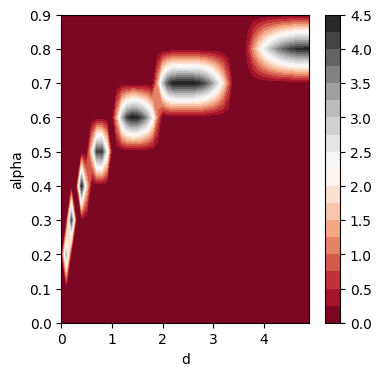

epoch 325 / 500 : loss = 106676.8203125
epoch 326 / 500 : loss = 106676.765625
epoch 327 / 500 : loss = 106676.7421875
epoch 328 / 500 : loss = 106676.6875
epoch 329 / 500 : loss = 106676.6484375


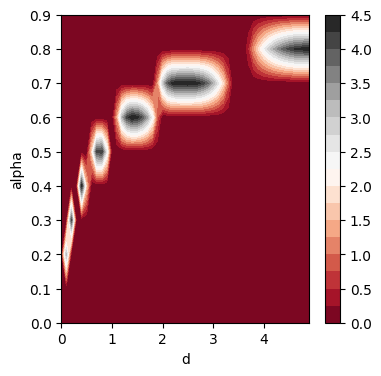

epoch 330 / 500 : loss = 106676.59375
epoch 331 / 500 : loss = 106676.5390625
epoch 332 / 500 : loss = 106676.5
epoch 333 / 500 : loss = 106676.453125
epoch 334 / 500 : loss = 106676.3984375


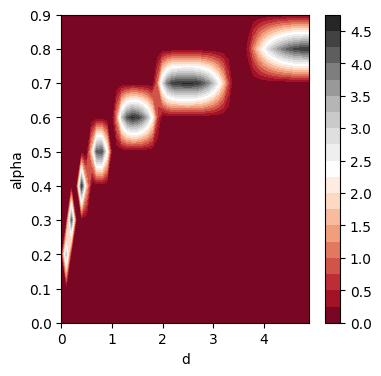

epoch 335 / 500 : loss = 106676.3515625
epoch 336 / 500 : loss = 106676.2890625
epoch 337 / 500 : loss = 106676.25
epoch 338 / 500 : loss = 106676.1953125
epoch 339 / 500 : loss = 106676.15625


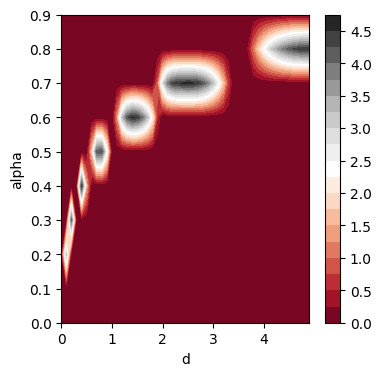

epoch 340 / 500 : loss = 106676.1015625
epoch 341 / 500 : loss = 106676.046875
epoch 342 / 500 : loss = 106676.03125
epoch 343 / 500 : loss = 106675.984375
epoch 344 / 500 : loss = 106675.9453125


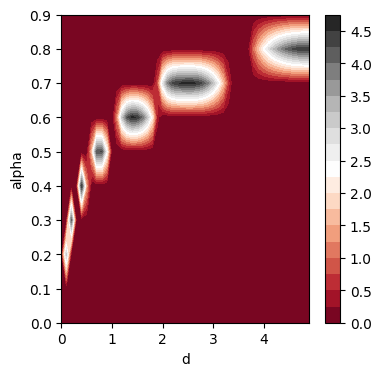

epoch 345 / 500 : loss = 106675.8984375
epoch 346 / 500 : loss = 106675.859375
epoch 347 / 500 : loss = 106675.8125
epoch 348 / 500 : loss = 106675.796875
epoch 349 / 500 : loss = 106675.7421875


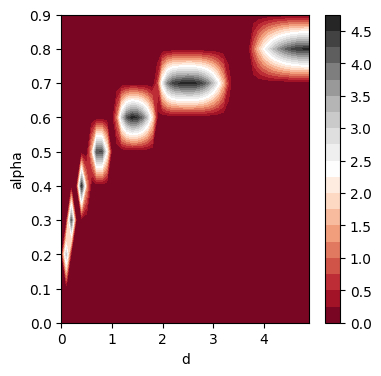

epoch 350 / 500 : loss = 106675.71875
epoch 351 / 500 : loss = 106675.6796875
epoch 352 / 500 : loss = 106675.625
epoch 353 / 500 : loss = 106675.6015625
epoch 354 / 500 : loss = 106675.5546875


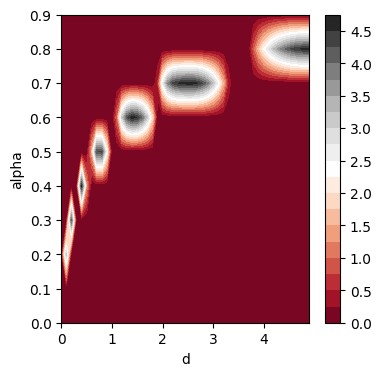

epoch 355 / 500 : loss = 106675.5
epoch 356 / 500 : loss = 106675.484375
epoch 357 / 500 : loss = 106675.421875
epoch 358 / 500 : loss = 106675.390625
epoch 359 / 500 : loss = 106675.3515625


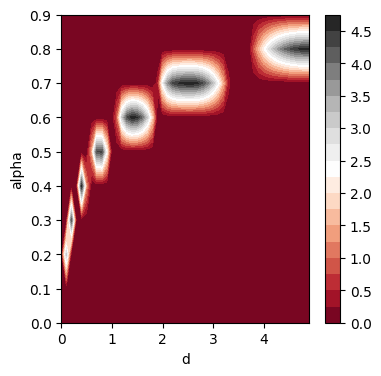

epoch 360 / 500 : loss = 106675.296875
epoch 361 / 500 : loss = 106675.265625
epoch 362 / 500 : loss = 106675.21875
epoch 363 / 500 : loss = 106675.171875
epoch 364 / 500 : loss = 106675.1328125


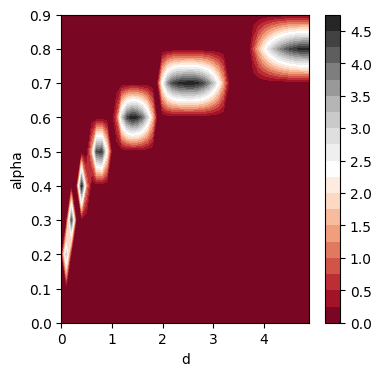

epoch 365 / 500 : loss = 106675.0859375
epoch 366 / 500 : loss = 106675.046875
epoch 367 / 500 : loss = 106675.015625
epoch 368 / 500 : loss = 106674.9921875
epoch 369 / 500 : loss = 106674.9453125


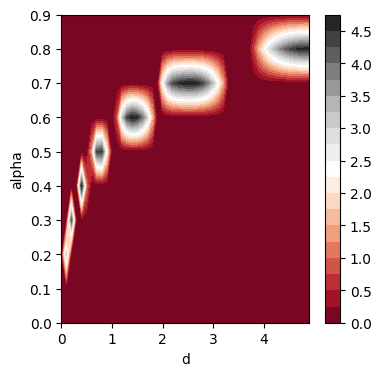

epoch 370 / 500 : loss = 106674.9296875
epoch 371 / 500 : loss = 106674.890625
epoch 372 / 500 : loss = 106674.8671875
epoch 373 / 500 : loss = 106674.8359375
epoch 374 / 500 : loss = 106674.796875


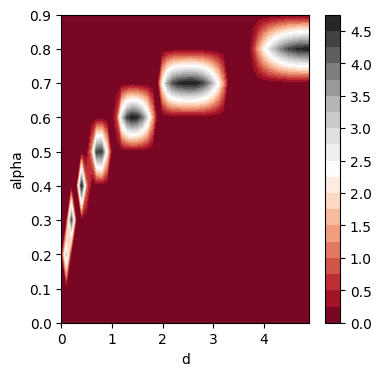

epoch 375 / 500 : loss = 106674.7734375
epoch 376 / 500 : loss = 106674.734375
epoch 377 / 500 : loss = 106674.6953125
epoch 378 / 500 : loss = 106674.65625
epoch 379 / 500 : loss = 106674.625


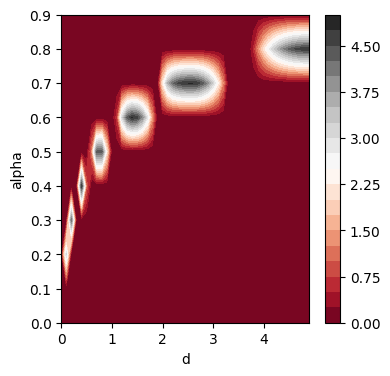

epoch 380 / 500 : loss = 106674.6015625
epoch 381 / 500 : loss = 106674.5625
epoch 382 / 500 : loss = 106674.5234375
epoch 383 / 500 : loss = 106674.484375
epoch 384 / 500 : loss = 106674.453125


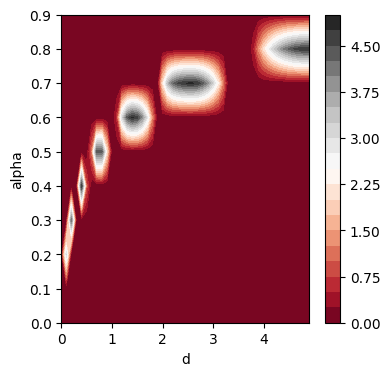

epoch 385 / 500 : loss = 106674.421875
epoch 386 / 500 : loss = 106674.390625
epoch 387 / 500 : loss = 106674.3515625
epoch 388 / 500 : loss = 106674.3046875
epoch 389 / 500 : loss = 106674.2578125


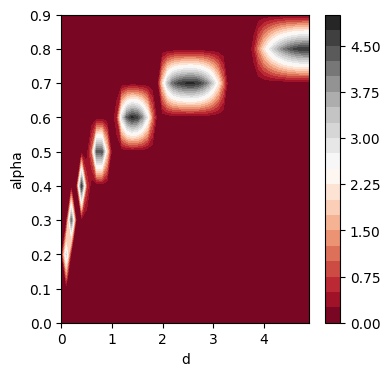

epoch 390 / 500 : loss = 106674.234375
epoch 391 / 500 : loss = 106674.1875
epoch 392 / 500 : loss = 106674.15625
epoch 393 / 500 : loss = 106674.1171875
epoch 394 / 500 : loss = 106674.09375


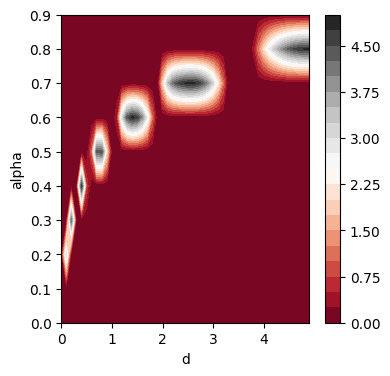

epoch 395 / 500 : loss = 106674.0703125
epoch 396 / 500 : loss = 106674.0390625
epoch 397 / 500 : loss = 106674.015625
epoch 398 / 500 : loss = 106673.984375
epoch 399 / 500 : loss = 106673.9609375


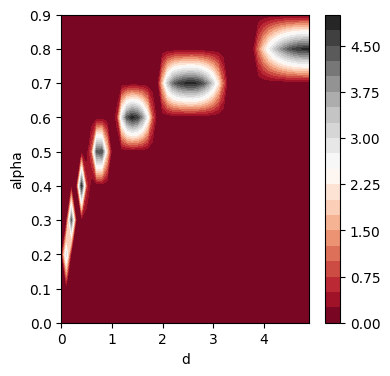

epoch 400 / 500 : loss = 106673.9140625
epoch 401 / 500 : loss = 106673.90625
epoch 402 / 500 : loss = 106673.875
epoch 403 / 500 : loss = 106673.84375
epoch 404 / 500 : loss = 106673.8203125


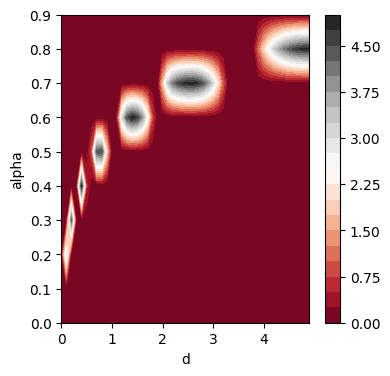

epoch 405 / 500 : loss = 106673.796875
epoch 406 / 500 : loss = 106673.7734375
epoch 407 / 500 : loss = 106673.734375
epoch 408 / 500 : loss = 106673.7109375
epoch 409 / 500 : loss = 106673.671875


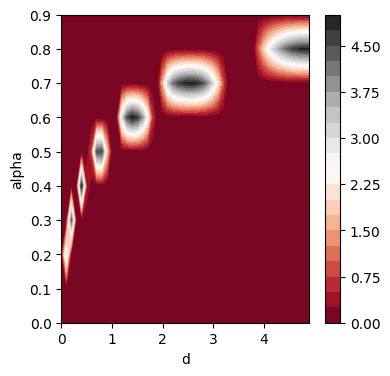

epoch 410 / 500 : loss = 106673.65625
epoch 411 / 500 : loss = 106673.6171875
epoch 412 / 500 : loss = 106673.6015625
epoch 413 / 500 : loss = 106673.5625
epoch 414 / 500 : loss = 106673.53125


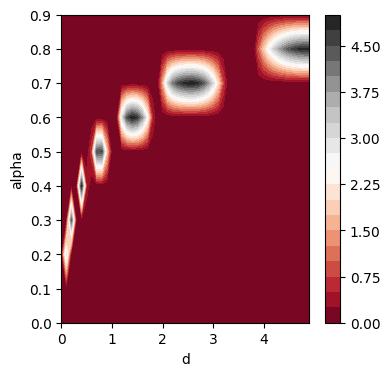

epoch 415 / 500 : loss = 106673.5078125
epoch 416 / 500 : loss = 106673.46875
epoch 417 / 500 : loss = 106673.4453125
epoch 418 / 500 : loss = 106673.40625
epoch 419 / 500 : loss = 106673.3828125


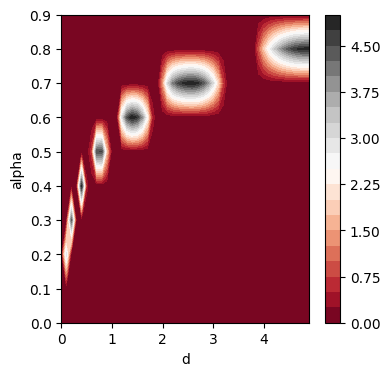

epoch 420 / 500 : loss = 106673.359375
epoch 421 / 500 : loss = 106673.3203125
epoch 422 / 500 : loss = 106673.3046875
epoch 423 / 500 : loss = 106673.234375
epoch 424 / 500 : loss = 106673.234375


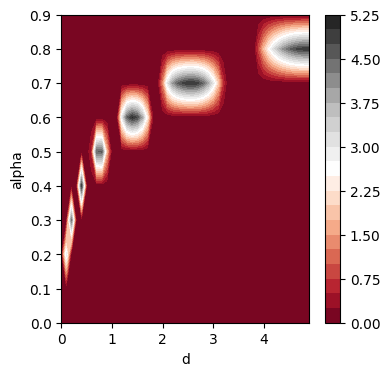

epoch 425 / 500 : loss = 106673.1953125
epoch 426 / 500 : loss = 106673.15625
epoch 427 / 500 : loss = 106673.1171875
epoch 428 / 500 : loss = 106673.109375
epoch 429 / 500 : loss = 106673.0859375


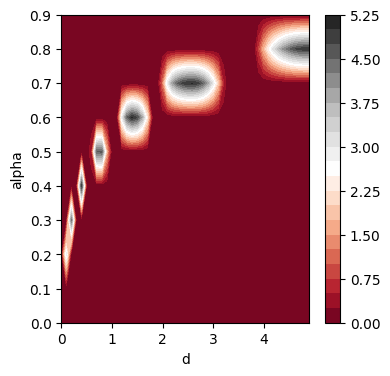

epoch 430 / 500 : loss = 106673.0625
epoch 431 / 500 : loss = 106673.046875
epoch 432 / 500 : loss = 106673.015625
epoch 433 / 500 : loss = 106673.0078125
epoch 434 / 500 : loss = 106672.96875


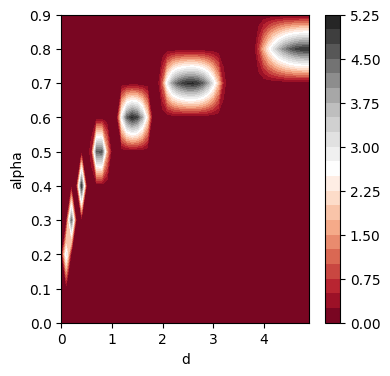

epoch 435 / 500 : loss = 106672.9453125
epoch 436 / 500 : loss = 106672.9453125
epoch 437 / 500 : loss = 106672.8984375
epoch 438 / 500 : loss = 106672.8828125
epoch 439 / 500 : loss = 106672.8671875


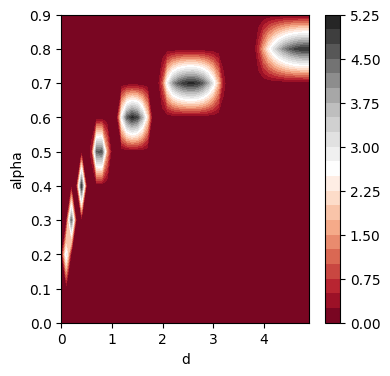

epoch 440 / 500 : loss = 106672.8203125
epoch 441 / 500 : loss = 106672.8203125
epoch 442 / 500 : loss = 106672.796875
epoch 443 / 500 : loss = 106672.7734375
epoch 444 / 500 : loss = 106672.7578125


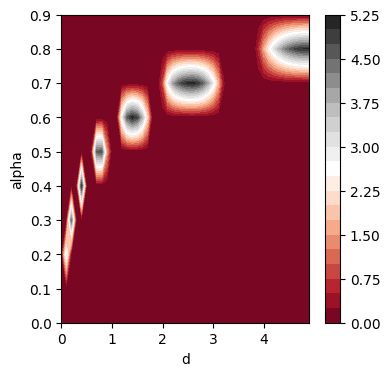

epoch 445 / 500 : loss = 106672.7265625
epoch 446 / 500 : loss = 106672.703125
epoch 447 / 500 : loss = 106672.6796875
epoch 448 / 500 : loss = 106672.65625
epoch 449 / 500 : loss = 106672.640625


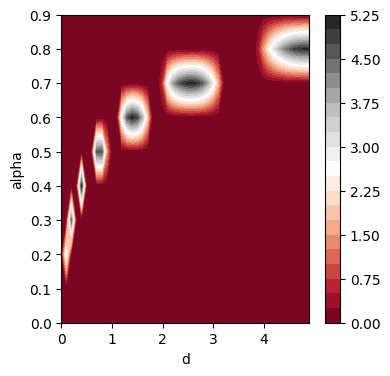

epoch 450 / 500 : loss = 106672.6015625
epoch 451 / 500 : loss = 106672.59375
epoch 452 / 500 : loss = 106672.546875
epoch 453 / 500 : loss = 106672.53125
epoch 454 / 500 : loss = 106672.5


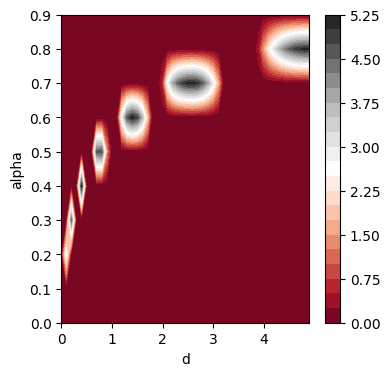

epoch 455 / 500 : loss = 106672.46875
epoch 456 / 500 : loss = 106672.453125
epoch 457 / 500 : loss = 106672.4140625
epoch 458 / 500 : loss = 106672.4140625
epoch 459 / 500 : loss = 106672.3828125


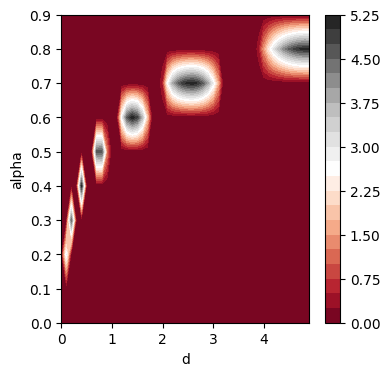

epoch 460 / 500 : loss = 106672.3515625
epoch 461 / 500 : loss = 106672.3203125
epoch 462 / 500 : loss = 106672.296875
epoch 463 / 500 : loss = 106672.2890625
epoch 464 / 500 : loss = 106672.234375


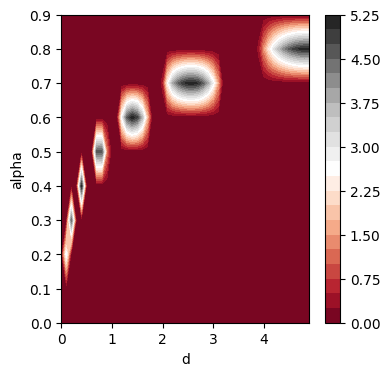

epoch 465 / 500 : loss = 106672.2265625
epoch 466 / 500 : loss = 106672.1875
epoch 467 / 500 : loss = 106672.1640625
epoch 468 / 500 : loss = 106672.140625
epoch 469 / 500 : loss = 106672.1328125


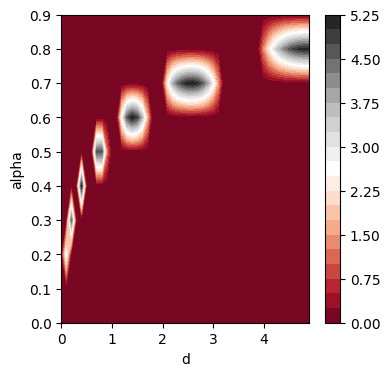

epoch 470 / 500 : loss = 106672.1171875
epoch 471 / 500 : loss = 106672.1015625
epoch 472 / 500 : loss = 106672.078125
epoch 473 / 500 : loss = 106672.0546875
epoch 474 / 500 : loss = 106672.0546875


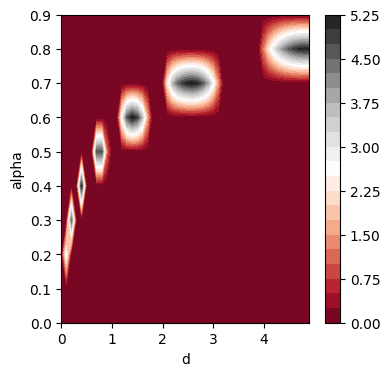

epoch 475 / 500 : loss = 106672.03125
epoch 476 / 500 : loss = 106672.0078125
epoch 477 / 500 : loss = 106672.0
epoch 478 / 500 : loss = 106671.9921875
epoch 479 / 500 : loss = 106671.9609375


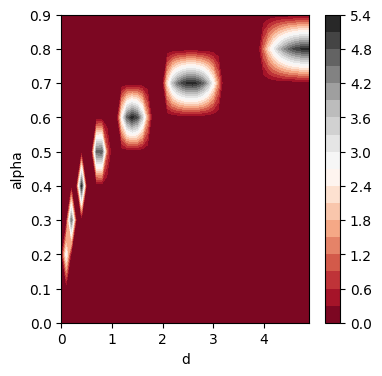

epoch 480 / 500 : loss = 106671.9375
epoch 481 / 500 : loss = 106671.9375
epoch 482 / 500 : loss = 106671.90625
epoch 483 / 500 : loss = 106671.890625
epoch 484 / 500 : loss = 106671.875


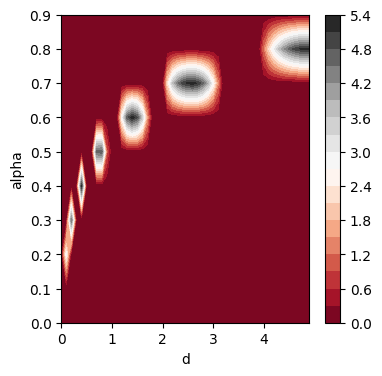

epoch 485 / 500 : loss = 106671.8359375
epoch 486 / 500 : loss = 106671.828125
epoch 487 / 500 : loss = 106671.8203125
epoch 488 / 500 : loss = 106671.7890625
epoch 489 / 500 : loss = 106671.765625


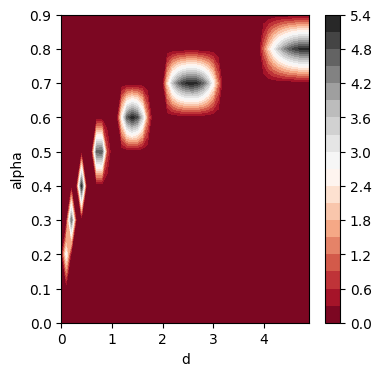

epoch 490 / 500 : loss = 106671.7578125
epoch 491 / 500 : loss = 106671.7265625
epoch 492 / 500 : loss = 106671.703125
epoch 493 / 500 : loss = 106671.6953125
epoch 494 / 500 : loss = 106671.6640625


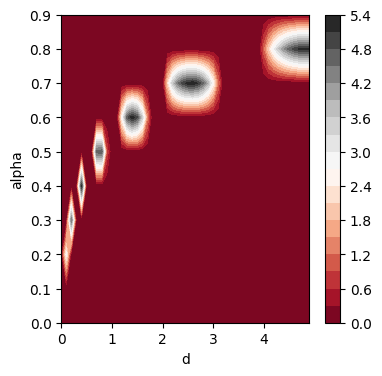

epoch 495 / 500 : loss = 106671.6484375
epoch 496 / 500 : loss = 106671.6328125
epoch 497 / 500 : loss = 106671.609375
epoch 498 / 500 : loss = 106671.59375
epoch 499 / 500 : loss = 106671.5859375


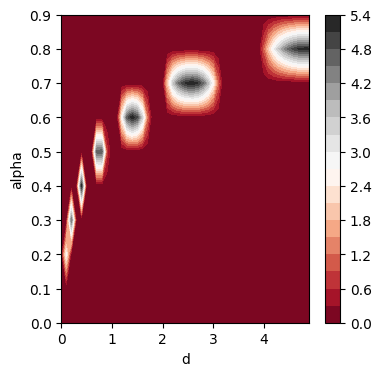

epoch 500 / 500 : loss = 106671.5546875


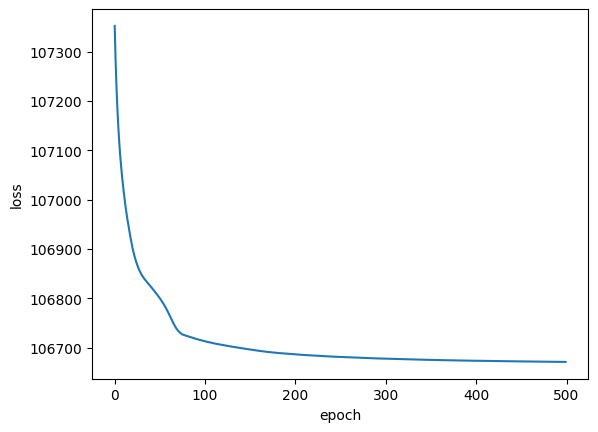

In [13]:
# train the model
P_alpha_d = train(P_alpha_d, u, Z, alpha_vals, d_vals, num_epochs=500, lr=1e-1)

In [18]:
P_alpha_d_cpu = P_alpha_d.cpu().detach().numpy()
# normalize P_alpha_d_cpu
# P_alpha_d_cpu = P_alpha_d_cpu / (P_alpha_d_cpu.sum(axis=(1,2), keepdims=True))
print(f"shape of P_alpha_d_cpu : {P_alpha_d_cpu.shape}")
# save P_alpha_d_cpu
np.save("P_alpha_d_cpu.npy", P_alpha_d_cpu)

shape of P_alpha_d_cpu : (100, 10, 50)


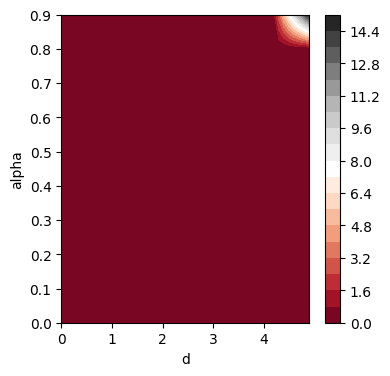

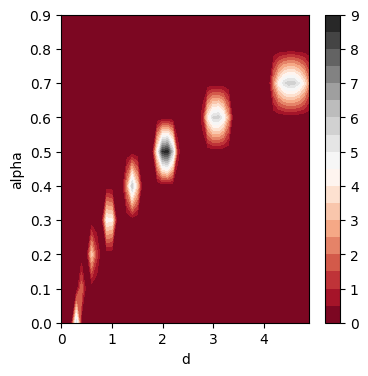

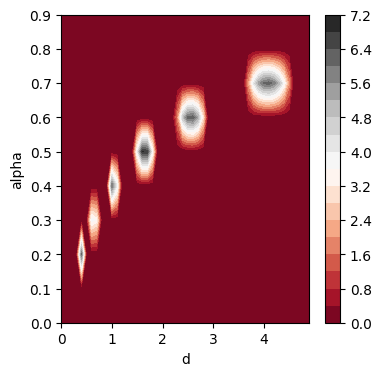

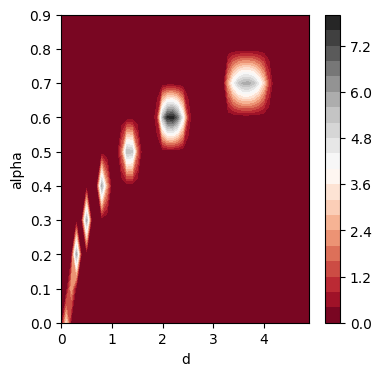

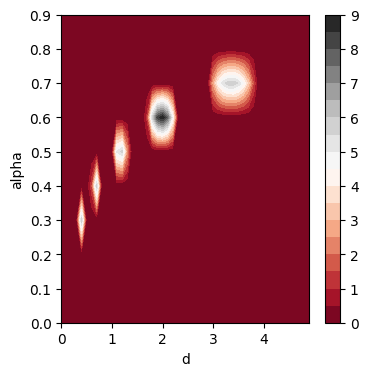

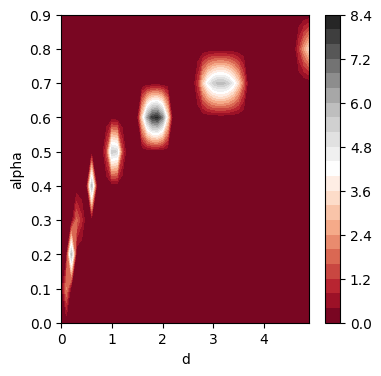

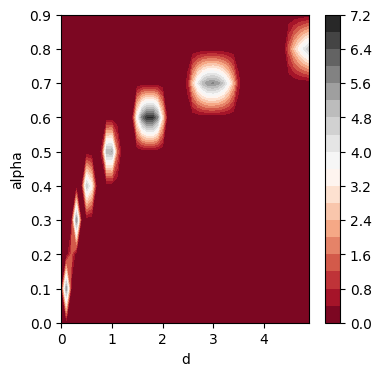

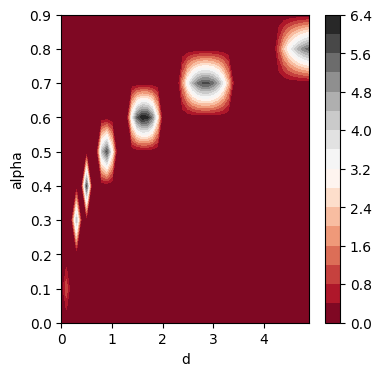

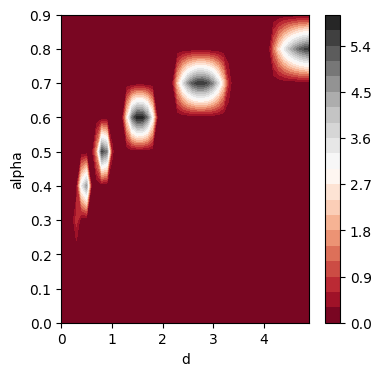

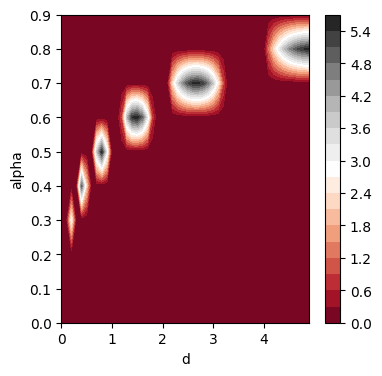

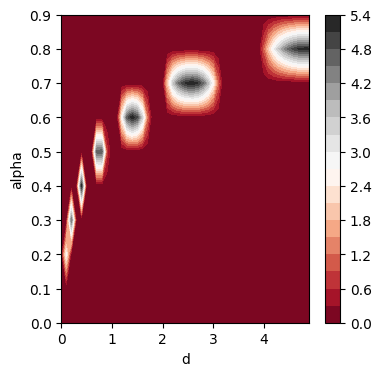

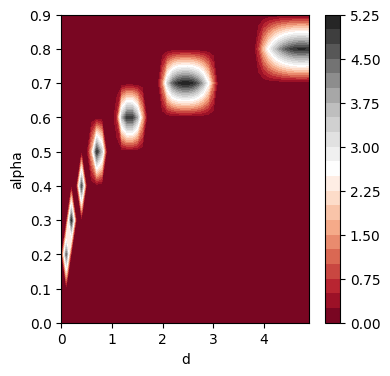

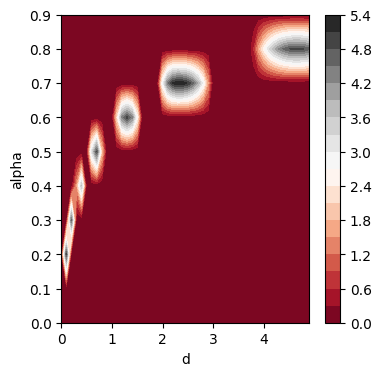

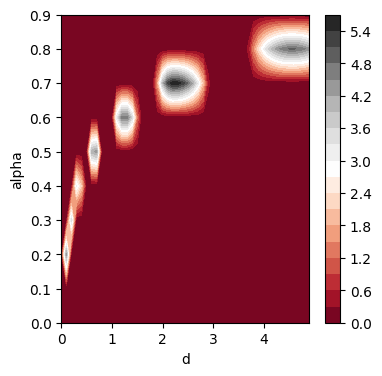

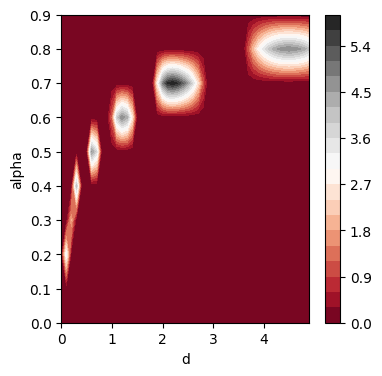

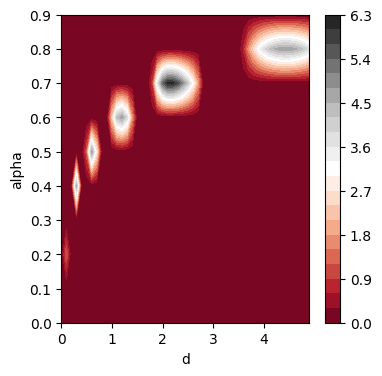

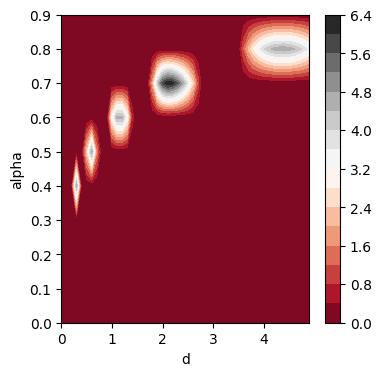

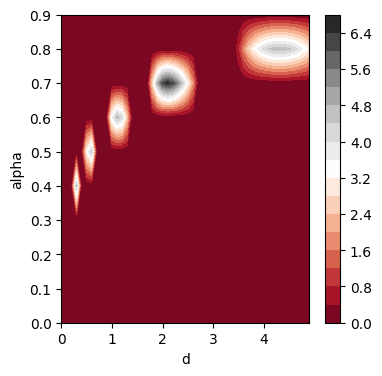

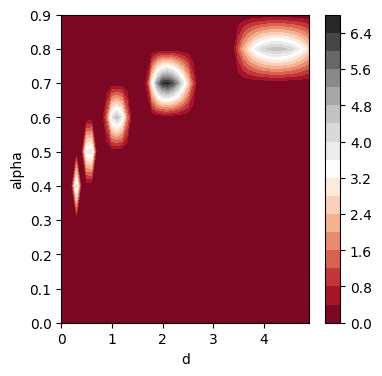

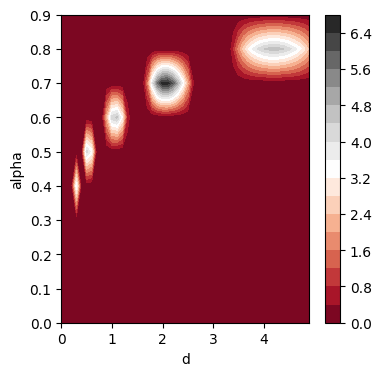

In [19]:
for i in range(0, num_frames, 5):
    # copy P_alpha_d to cpu
    contour_plt(P_alpha_d_cpu, i)

In [20]:
def give_u_pred_np_and_plot(P_alpha_d, Z, alpha_vals, d_vals, r_vals):
    """
    Given P_alpha_d, Z, alpha_vals, d_vals, return u_pred
    """
    # initialize u_pred
    u_pred = np.zeros((num_frames, len(r_vals)))

    # convert P_alpha_d to numpy array
    P_alpha_d = P_alpha_d.cpu().detach().numpy()
    Z = Z.cpu().detach().numpy()
    alpha_vals = alpha_vals.cpu().detach().numpy()
    d_vals = d_vals.cpu().detach().numpy()

    for i in range(u_pred.shape[0]):
        for j in range(u_pred.shape[1]):
            integrand = np.trapz(P_alpha_d[i] * Z[:, :, i, j], d_vals, axis=1)
            u_pred[i, j] = np.trapz(integrand, alpha_vals)

    # normalize u_pred
    u_pred = u_pred / (u_pred.sum(axis=1, keepdims=True) + 1e-6)
    # u_pred = u_pred / (u_pred.sum(axis=1, keepdims=True))

    # s_vals = np.linspace(0.0, 2*np.pi, 101)
    s_vals = np.linspace(0.0, 1000, 101)
    s_vals[0] = 1e-10
    s_vals = s_vals[:-1]

    # get the range of k values
    # convert r_vals to numpy array
    r_vals = r_vals.cpu().detach().numpy()
    k_vals = fft.fftfreq(r_vals.shape[0], d=r_vals[1]-r_vals[0])
    # k_vals = 2 * np.pi * k_vals
    # print(k_vals)
    print(f"shape of k_vals : {k_vals.shape}")

    # visualize u_pred
    plt.figure(figsize=(10, 8))
    plt.title("u_pred(s, k) for some s values")
    plt.xlabel("k")
    plt.ylabel("u_pred(s, k)")
    plt.grid()
    for i in range(0, s_vals.shape[0], 10):
        if i == 0:
            continue
        plt.plot(k_vals, u_pred[i, :], label=f"s = {s_vals[i]:.2f}")

    plt.legend()
    plt.show()

shape of k_vals : (500,)


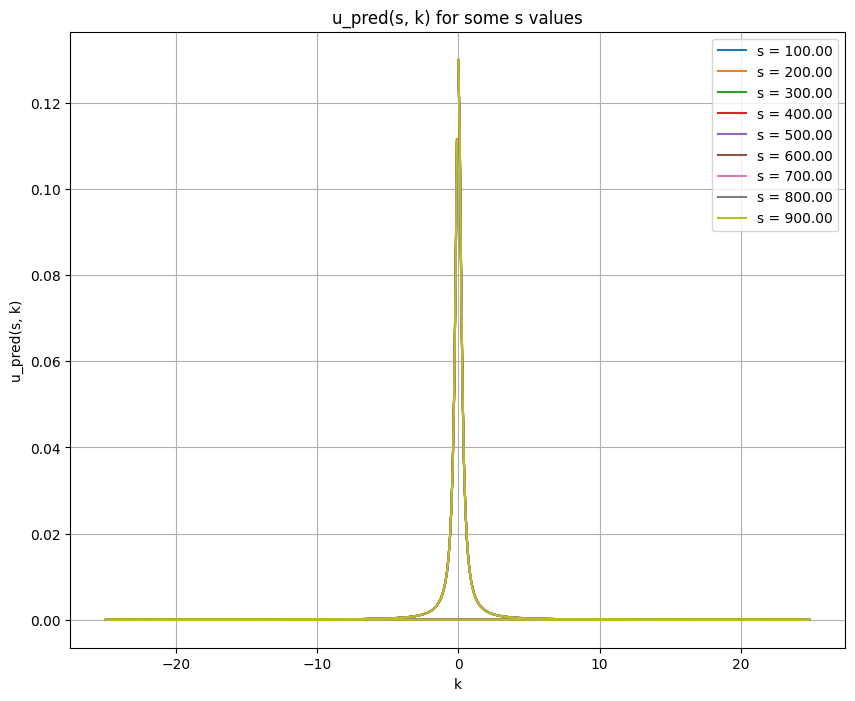

In [21]:
# reproduce u_pred
give_u_pred_np_and_plot(P_alpha_d, Z, alpha_vals, d_vals, r_vals)
